In [1]:
import pandas as pd ; import requests ; import io ; import re
import nltk ; from nltk.corpus import stopwords ; import string
import itertools ; import os ; from tqdm import tqdm ; import json
from wordcloud import WordCloud ; import matplotlib.pyplot as plt
import datetime ; import numpy as np ; from collections import Counter
import shifterator as sh ; import networkx as nx ; import netwulf as nw
from netwulf import visualize ; from networkx import Graph ; import random
from community import community_louvain ; import matplotlib as mpl
seed = 42
np.random.seed(seed)
random.seed(seed)


#url1 = "https://raw.githubusercontent.com/JaQtae/SocInfo2022/FinalProject/politics_subs_smol.csv"
#url2 = "https://raw.githubusercontent.com/JaQtae/SocInfo2022/FinalProject/politics_comments.csv"

#download_sub = requests.get(url1).content
#download_com = requests.get(url2).content

#sub_data = pd.read_csv(io.StringIO(download_sub.decode('utf-8')))
#com_data = pd.read_csv(io.StringIO(download_com.decode('utf-8')))


In [9]:
# Since json was corrupted, we redo week 3
sub_data = pd.read_csv('politics_subs_smol.csv', 
                      parse_dates = ['Unnamed: 0'], sep=',').set_index('Unnamed: 0')

sub_data.index = sub_data.index.rename('dates')
cd_ = pd.read_csv('politics_comments.csv', 
                       parse_dates = ['Unnamed: 0'], sep=',').set_index('Unnamed: 0')
cd_.index = cd_.index.rename('dates')


com_authors = dict(zip(cd_['id'], cd_['author']))
parent = dict(zip(cd_['id'], cd_['parent_id']))
sub_authors = dict(zip(sub_data['id'], sub_data['author']))

def authID(com_id):
    if parent[com_id][:3] == "t1_":
        auth = com_authors.get(parent[com_id][3:], None)
    else:
        auth = sub_authors.get(parent[com_id][3:], None)
    return auth

cd_['parent_author'] = cd_['id'].apply(authID)

# Limited by day
cd_ = cd_[(cd_.index < '2020-11-07')]

cd_ = cd_.drop(cd_[cd_['author'] == '[deleted]'].index) # remove deleteds
cd_ = cd_.drop(cd_[cd_['parent_author'] == '[deleted]'].index) # Remove deleteds
cd_ = cd_.drop(cd_[cd_['parent_author'].isna()].index) # Remove NaN's
cd_ = cd_.drop(cd_[cd_['author'] == 'AutoModerator'].index)
cd_ = cd_.drop(cd_[cd_['author'] == 'PoliticsModeratorBot'].index)

In [10]:
#Pruning
TB = []
for i in range(len(sub_data['title'])):
    if (re.search('Trump', sub_data['title'][i])) and (re.search('Biden', sub_data['title'][i])):
        TB.append(i)
    else:
        continue
sub_data_pruned = sub_data.drop(sub_data.index[TB])
print(len(TB))
print(TB[0])

2650
22


In [11]:
cd_['author'].value_counts()

uping1965       1076
PetGodzilla      823
Enjolras55       808
ImInterested     702
MBAMBA3          690
                ... 
bequeami           1
D-F-B-81           1
Loraura            1
dipset6776         1
Booomerz           1
Name: author, Length: 233173, dtype: int64

In [12]:
# Limit
vc = cd_.author.value_counts()
cd_[cd_.author.isin(vc.index[vc.values >= 5])].author.value_counts()

uping1965          1076
PetGodzilla         823
Enjolras55          808
ImInterested        702
MBAMBA3             690
                   ... 
Paralysah             5
SimpleWayfarer        5
Dish_Washington       5
hgcjoircbjk           5
PedanticPaladin       5
Name: author, Length: 52064, dtype: int64

In [13]:
cd_ = cd_.drop(cd_[cd_.author.isin(vc.index[vc.values >= 5])].index)

In [14]:
cd_['id'].resample('D').count()

dates
2020-09-30      43
2020-10-01    4194
2020-10-02    9389
2020-10-03    4507
2020-10-04    4489
2020-10-05    5194
2020-10-06    6396
2020-10-07    5933
2020-10-08    6291
2020-10-09    4881
2020-10-10    4532
2020-10-11    3343
2020-10-12    2891
2020-10-13    3947
2020-10-14    3214
2020-10-15    4378
2020-10-16    6035
2020-10-17    8656
2020-10-18    3732
2020-10-19    2638
2020-10-20    3184
2020-10-21    6616
2020-10-22    5037
2020-10-23    6382
2020-10-24    4228
2020-10-25    4501
2020-10-26    6603
2020-10-27    6483
2020-10-28    5353
2020-10-29    6218
2020-10-30    4906
2020-10-31    6352
2020-11-01    3818
2020-11-02    7234
2020-11-03    3062
2020-11-04     251
2020-11-05       0
2020-11-06      40
Freq: D, Name: id, dtype: int64

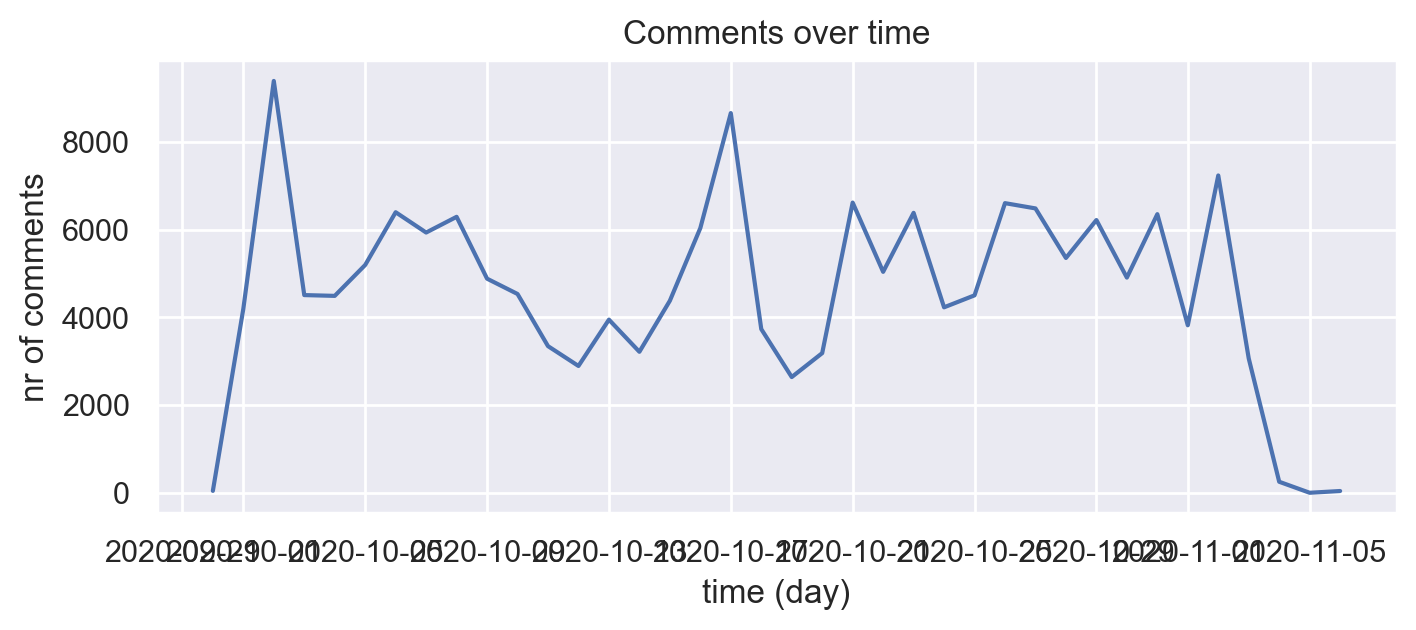

In [15]:
import seaborn as sns
import matplotlib as mpl
sns.set_theme()

daily_com = cd_['id'].resample('D').count()

# Data for plotting
t = daily_com.index
s = daily_com
fig, ax = plt.subplots(figsize=(8,3), dpi=200)
ax.plot(t, s)
ax.set(xlabel='time (day)', ylabel='nr of comments',
       title='Comments over time')

plt.show()

In [17]:
cd_test = cd_.groupby(cd_.index.date).count()
cd_test = cd_test.set_index(pd.DatetimeIndex(cd_test.index))
cd_t_wvol = cd_test.rolling('7D').mean()
#cd_test

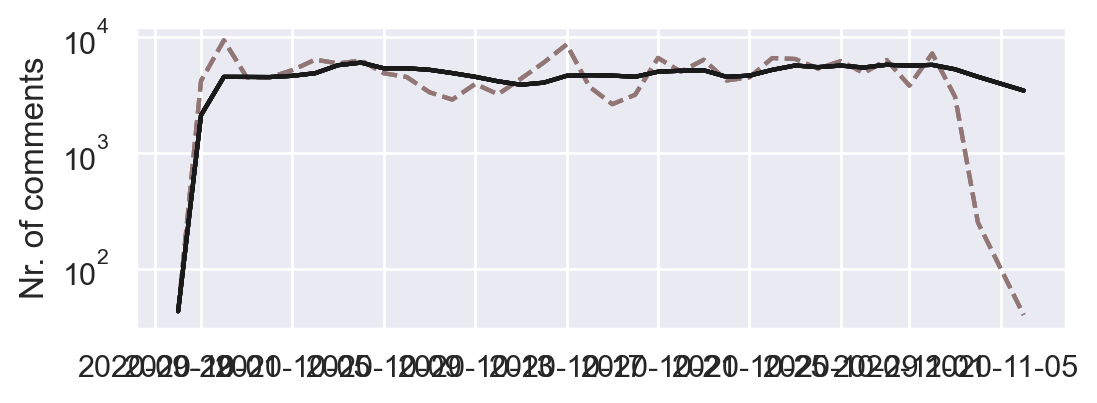

In [18]:
fig, ax = plt.subplots(figsize=(6,2), dpi=200)
ax.plot(cd_test.index, cd_test.values, ls='--', alpha=0.5)
ax.plot(cd_t_wvol.index, cd_t_wvol.values, color='k', label='1 week rolling')
ax.set_ylabel('Nr. of comments')
ax.set_yscale('log')
plt.show()

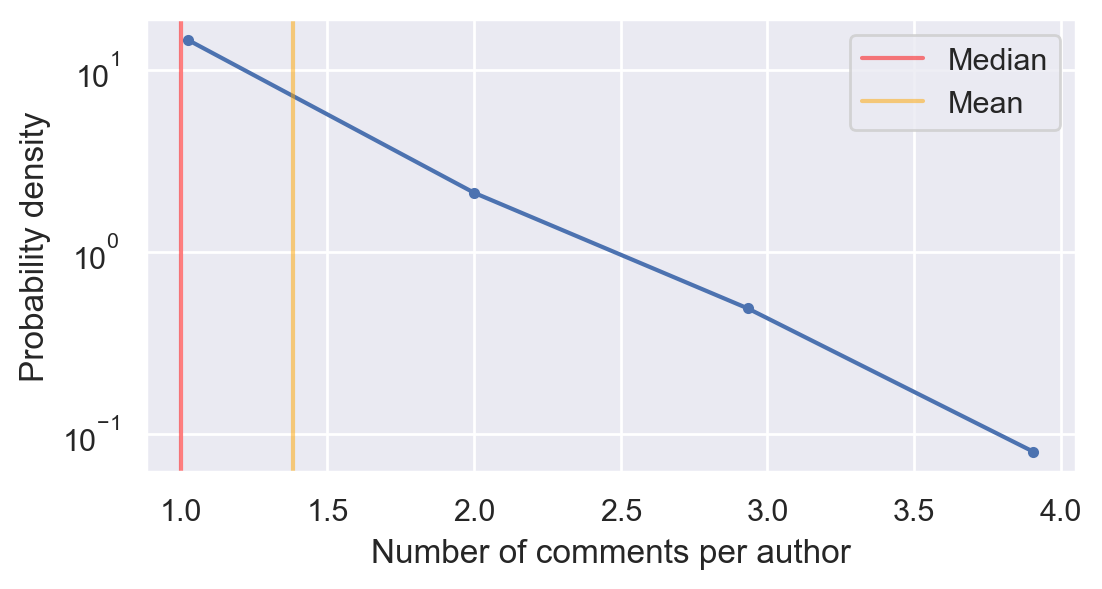

In [25]:
com_pr_auth = cd_.groupby('author').size()
bins = np.logspace(np.log10(min(com_pr_auth)), np.log10(max(com_pr_auth)), 30)
hist, edges = np.histogram(com_pr_auth, bins = bins, density = True)
x = (edges[1:] + edges[:-1])/2
# Removing entry bins
xx, yy = zip(*[(i,j) for (i,j) in zip(x,hist) if j>0])
fig, ax = plt.subplots(dpi=200, figsize=(6,3))
ax.plot(xx, yy, marker=".")
ax.axvline(x=np.median(com_pr_auth), label = "Median", color='red', alpha=0.5)
ax.axvline(x=np.mean(com_pr_auth), label='Mean', color='orange', alpha=0.5)
ax.set_xlabel('Number of comments per author')
ax.set_ylabel('Probability density')
#ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
plt.show()